In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import xgboost as xgb

In [3]:
# Read in data and filter to time frame
file_name = ""
df_load = dataiku.Dataset(file_name).get_dataframe()
df= df_load.copy()

In [4]:
def prediction_scope(df_in, start_i, end_i):
    start_date = pd.Timestamp(start_i)
    end_date = pd.Timestamp(end_i)

    df = df_in.loc[lambda x: x.event_date.between(start_date, end_date)]
    
    return df

In [188]:
# XGBoost PREDICTION CLASS FOR TIMESERIES DATA
class timeseries_xgb():

    
    def __init__(self, df_in, target, date_field, num_periods, xgb_kwargs, verbose, freq):
        self.df_in = df_in
        self.date = date_field
        assert date_field in df_in.columns, "Input data does not contain the date field"
        # Sort values by date
        self.df_in = self.df_in.set_index(self.date).sort_index()
        
        self.target = target
        assert target in df_in.columns, "Input data does not contain the target" 
        
        self.freq = freq
        self.num_periods = num_periods
        self.xgb_kwargs = xgb_kwargs
        self.score = None
        self.train_preds = None
        self.sc = None
        self.verbose = verbose
        
        
    def shift_target(self):
        # Add target (i.e predict sales in n periods)
        target_name = f"{self.target}_plus_{self.num_periods}{self.freq}"
        target_o = self.df_in[self.target].shift(-self.num_periods).rename(target_name).dropna()
        return target_o
        
        
    def prepare_data(self, data, fit=False):
        # Standard scale features
        if fit:
            self.sc = StandardScaler()
            output_array = self.sc.fit_transform(data)
        else:
            assert self.sc is not None, "Please fit the scaler first"
            output_array = self.sc.transform(data)
        output = pd.DataFrame(output_array, index = data.index, columns = data.columns)
        return output
    

    def train_test(self, train_size, nbr):
        y = self.shift_target()
        X = self.df_in.reindex(y.index, axis=0).drop([self.target], axis=1)

        # Training sample - train_size% of historical chronoligical data
        split_date = X.head(int(len(df)*train_size)).index[-1]
        if self.verbose:
            print(f"train/test split at {split_date}")
                      
        self.X_train = X.loc[:split_date, :].sample(frac=1, random_state=42)
        self.y_train = y.loc[:split_date]
        
        # Test data - most recent 1 - train_size% data - chronological order preserved
        self.X_test = X.loc[lambda x: x.index > split_date, :]
        self.y_test = y.loc[lambda x: x.index > split_date]
        base_score = np.mean(self.y_train)

        if self.verbose:
            print("X train / test size", len(self.X_train), len(self.X_test))
            print("y train / test size", len(self.y_train), len(self.y_test))
            

        # Fit XGBoost
        self.X_train_transformed = self.prepare_data(self.X_train, fit=True)
        dtrain = xgb.DMatrix(self.X_train_transformed, self.y_train)
        self.model = xgb.train(dict(self.xgb_kwargs, base_score=base_score), dtrain, num_boost_round=nbr)
        
        self.dumb = lambda x: [self.y_train.mean()]*len(x)
        
        # Make prediction for test data
        self.results = self.predict(self.X_test)[['y_pred']].assign(y_mean= lambda x: self.dumb(x))
        y_pred = self.results['y_pred'].shift(-self.num_periods, freq=self.freq).dropna()
        
        # Call score model function
        self.score_model(y_pred, self.y_test)

        return self
    
    
    # Predict y from input dataframe - calling prepare data in process
    def predict(self, df_in):
        if self.date in df_in.columns:
            df_in = df_in.set_index(self.date)
         
        df_in_transformed = df_in.pipe(self.prepare_data)
        df_matrix = xgb.DMatrix(df_in_transformed)
        y_pred_array = self.model.predict(df_matrix) 
        y_pred = pd.Series(y_pred_array,
                           index = df_in.index.shift(self.num_periods, freq=self.freq),
                           name='y_pred'
                 )
        output = df_in.join(y_pred, how='outer')
        return output
     
    
    # Score predictions against test and baseline dumb_model
    def score_model(self, y_pred, y_test):
        # Get scores of model
        dumb_score = np.sqrt(metrics.mean_squared_error(y_test, self.dumb(y_test)))
        self.score = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        if self.verbose:
            print('RMSE: (dumb model):', dumb_score)
            print('RMSE:', self.score, '\n')

    
    # Plot the prediction against the actual and dumb mean model
    def plot(self, title=''):
        #plot_data = pd.concat([self.y_train.sort_index(), self.y_test], axis=0).to_frame().join(self.results)
        ys =[self.target, "y_pred", "y_mean"]
        plot_data = self.df_in.join(self.results)[ys]
        line_style = ['g-+', 'r-o', 'k-']
        plt.figure(figsize=(15,10))
        for i,col in enumerate(plot_data.columns):
            plt.plot(plot_data[col], line_style[i])
        plt.title(title)
        plt.grid(True)
        plt.legend(ys)

In [238]:
# CREATE GRIDSEARCH FUNCTION
from itertools import product

def define_grid(grid_dictionary):
    return iter({a:b for a,b in zip(grid_dictionary.keys(),params)} for params in product(*grid_dictionary.values()))


def xgb_gridsearch(df_in, xgb_params_dict_i, static_xgb_params_dict_i, target_i, num_periods, 
                   freq, event_i, select_cols_i, train_i, nbr, verbose=True):
    results = []
    for params in define_grid(xgb_params_dict_i):
        params.update(static_xgb_params_dict_i)
        
        m = timeseries_xgb(df_in, target = target_i, date_field = event_i, num_periods=num_periods,
                           xgb_kwargs = params, verbose = verbose, freq=freq)
        m.train_test(train_size=train_i, nbr=nbr)
        results.append(m)
    return results


# GET BEST MODEL AND SCORE
def grid_best_model(results_list):
    best_score = min([model.score for model in results_list])
    best_models = [model for model in results_list if model.score == best_score]
    print("best_score: ", best_score)

    for model in best_models:
        print(model.xgb_kwargs)
        
    return best_score, best_models


# Now for the best parameters, iterate over the train/test split difference
def iterate_split_ratio(df_test, target_i, date_field, num_periods, freq, params_i, 
                        x0=0.65, x1=0.85, n=10, nbr=250, verbose=True):
    for split_ratio in linspace(x0, x1, n):
        m = timeseries_xgb(df_test, target = target_i, date_field = event_i, num_periods=num_periods,
                           xgb_kwargs = params, verbose = verbose, freq=freq)
        m.train_test(train_size=split_ratio, nbr=nbr)
        m.plot(title = f"Score :{m.score}, ratio: {split_ratio}")

### 1. MODEL 1 - ALL FEATURES, ALL TIME

best_score:  44973.53900689709
{'eta': 0.21, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.595, 'lambda': 0.7, 'alpha': 0.75, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}


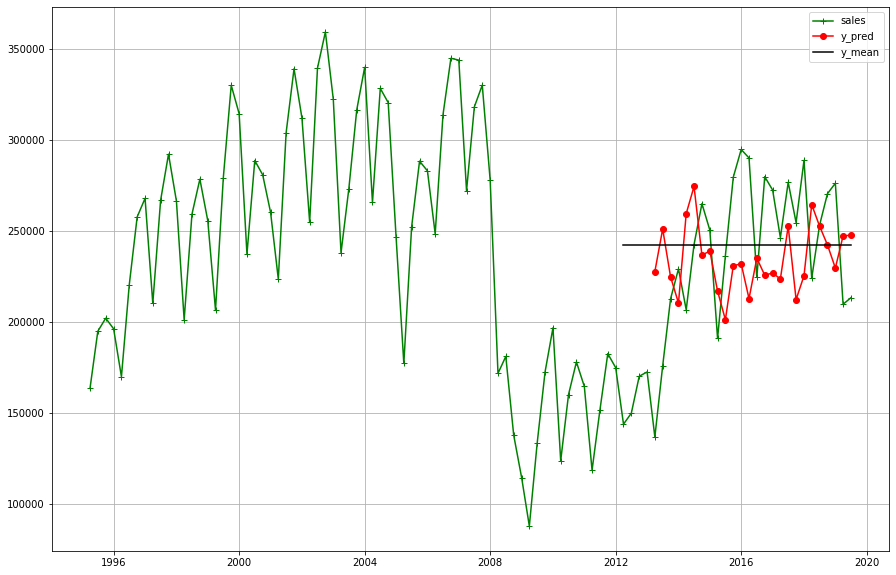

In [228]:
# Call data scope function
df = prediction_scope(df_load, '1995-03-31', '2019-06-30')

# GRIDSEARCH INPUTS
target_i = "sales"
event_i = 'event_date'
select_cols = [c for c in df.columns]
train_i = 0.7

xgb_params = {
    'eta': [0.21],
    'max_depth': [9],
    'min_child_weight': [1],
    'subsample': [0.595],
    'lambda': [0.7],   
    'alpha': [0.75]
}
xgb_static_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
#     'verbosity': 1
}

results = xgb_gridsearch(df, xgb_params, xgb_static_params, target_i, 4, 'Q', event_i, 
                         select_cols, train_i, nbr=250, verbose=False)

# Call grid_best_model function
best_score, best_models = grid_best_model(results)

# To investigate results against different parameters
# for model in results:
#     print(model.xgb_kwargs)
#     model.plot(title = f"Score :{model.score}")

best_models[0].plot()

train/test split at 2010-09-30 00:00:00
X train / test size 63 31
y train / test size 63 31
RMSE: (dumb model): 49814.47139969939
RMSE: 65770.31345459078 

train/test split at 2011-03-31 00:00:00
X train / test size 65 29
y train / test size 65 29
RMSE: (dumb model): 44926.862934528726
RMSE: 61799.57575802879 

train/test split at 2011-12-31 00:00:00
X train / test size 68 26
y train / test size 68 26
RMSE: (dumb model): 38226.90256339153
RMSE: 52075.362033818776 

train/test split at 2012-06-30 00:00:00
X train / test size 70 24
y train / test size 70 24
RMSE: (dumb model): 31309.624981845045
RMSE: 55262.14692288235 

train/test split at 2012-12-31 00:00:00
X train / test size 72 22
y train / test size 72 22
RMSE: (dumb model): 32321.83108798949
RMSE: 45590.9772315017 

train/test split at 2013-06-30 00:00:00
X train / test size 74 20
y train / test size 74 20
RMSE: (dumb model): 33292.290654379256
RMSE: 39742.368506232495 

train/test split at 2013-12-31 00:00:00
X train / test size 

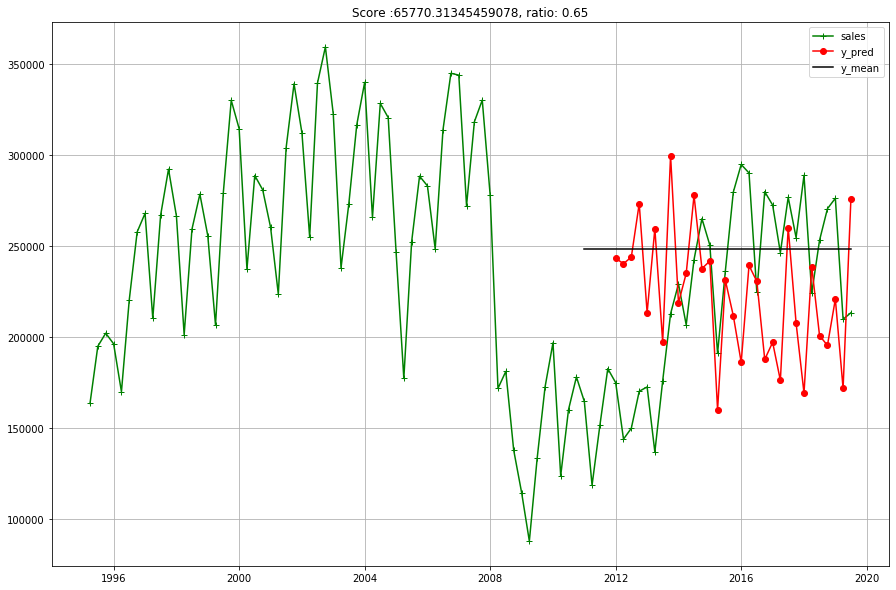

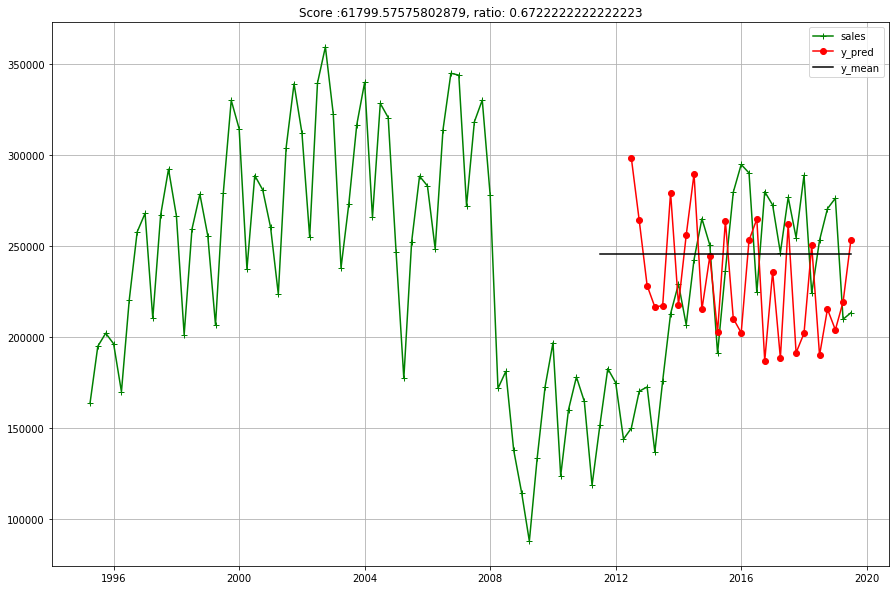

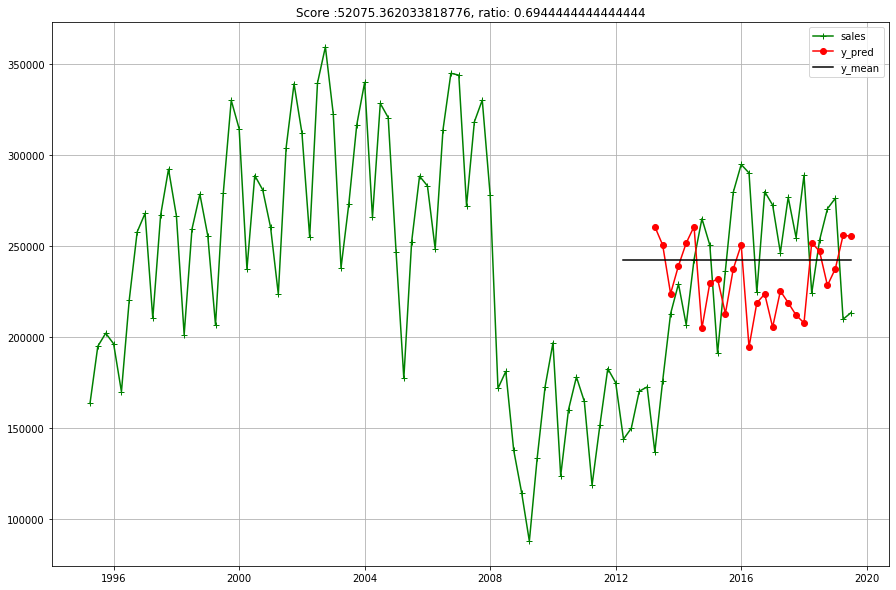

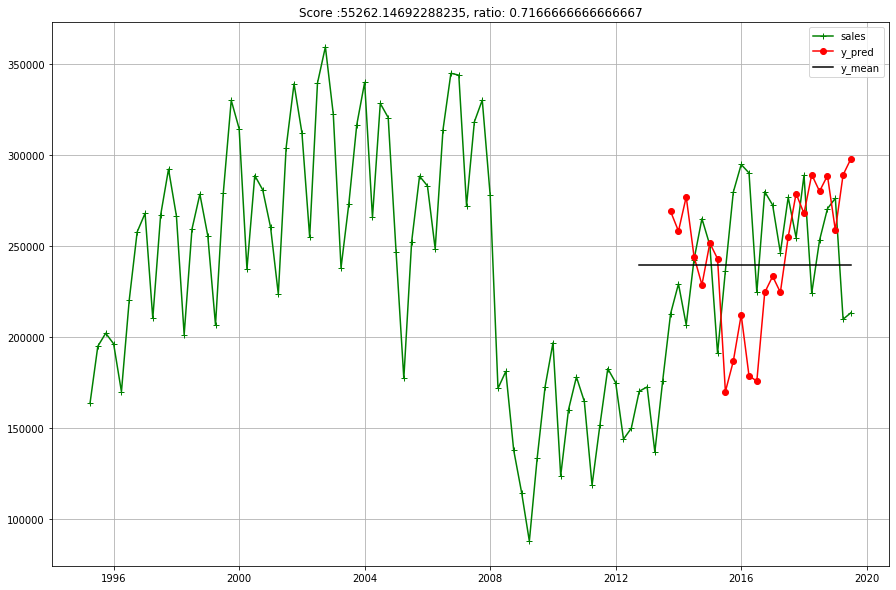

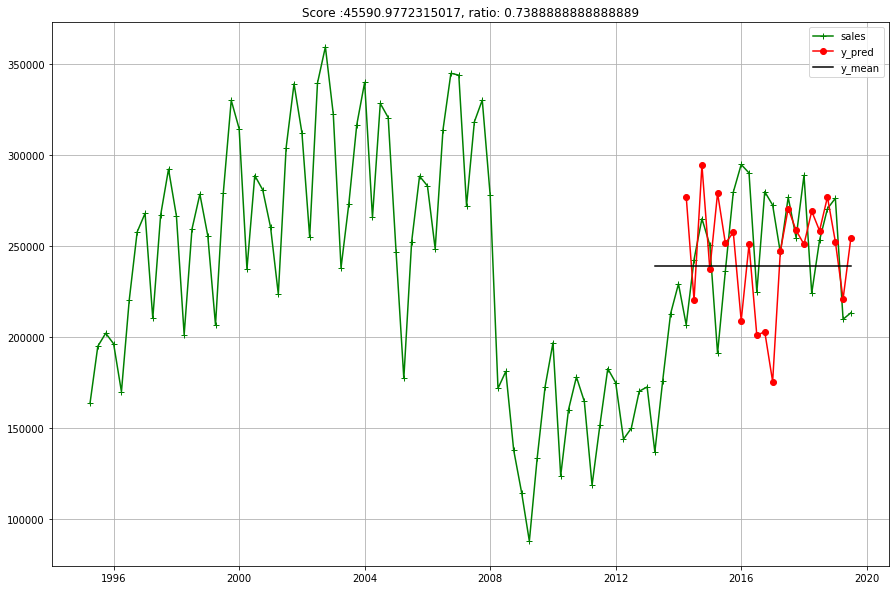

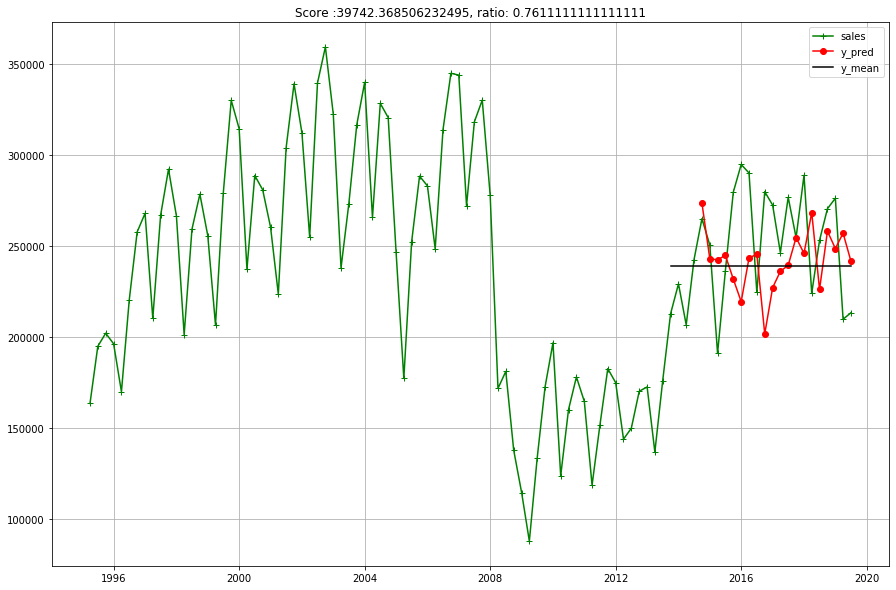

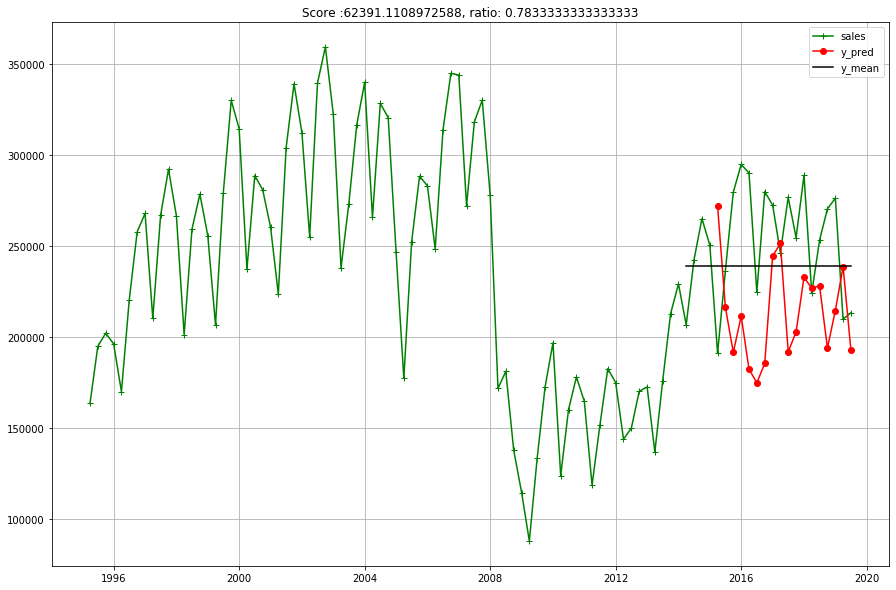

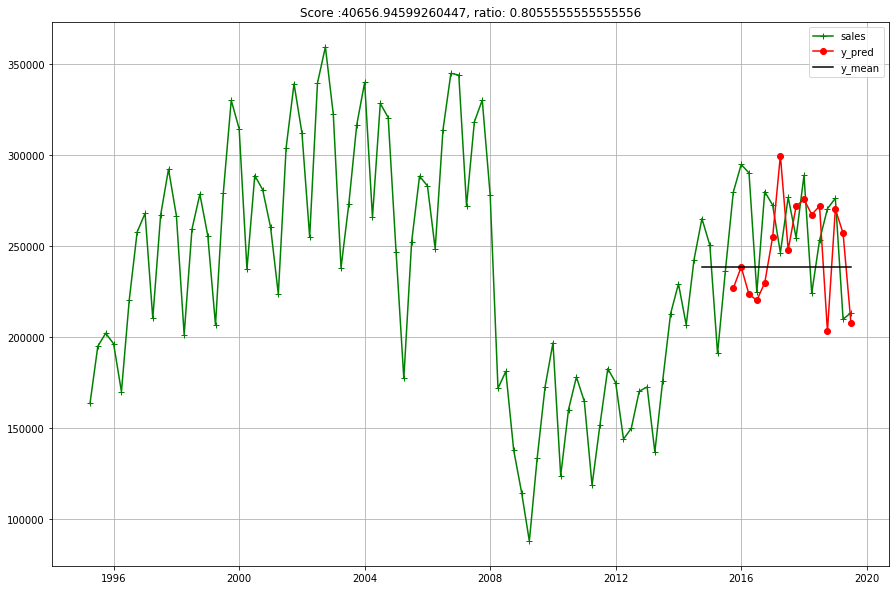

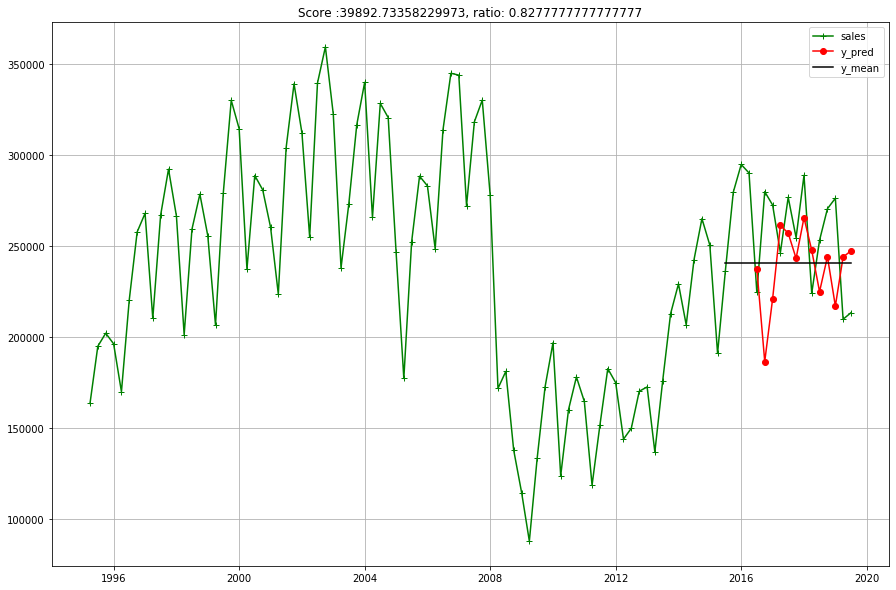

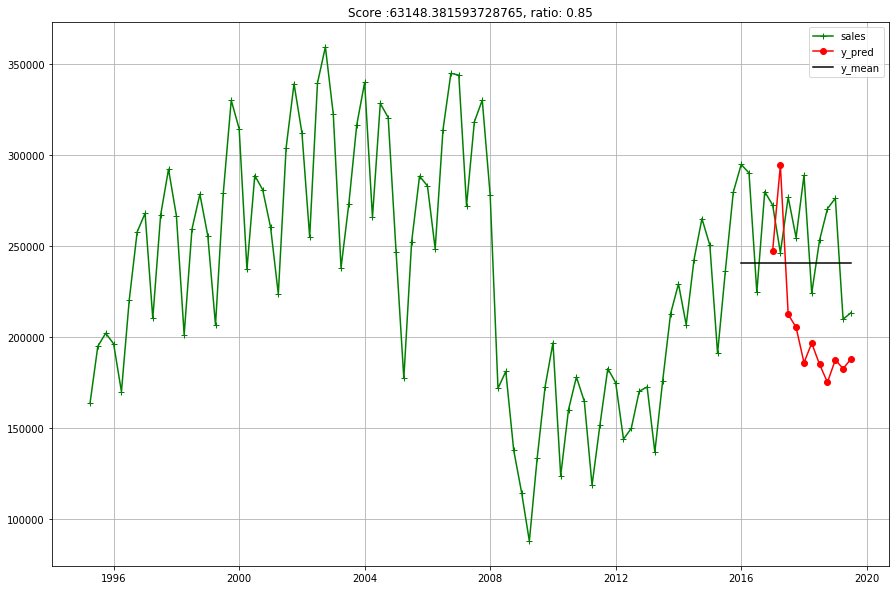

In [229]:
# Check stability across different training ratios
chosen_params = best_models[0].xgb_kwargs

iterate_split_ratio(df_load, target_i, event_i, 4, 'Q', chosen_params, 
                        x0=0.65, x1=0.85, n=10, nbr=250, verbose=True)